In [1]:
#import libraries
import pandas as pd
import numpy as np
import itertools
import networkx as nx
from scipy.cluster import hierarchy
import scipy.spatial.distance as ssd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import math
pd.options.mode.chained_assignment = None 
sns.set(font='Times New Roman')
sns.set(font_scale=1.5)
import re
import csv
import os

In [2]:
df_weekly_sum = pd.read_csv('dpgr_who_continets.csv')
print(df_weekly_sum.head())

  Variant                   Date       Location  Freq
0   Alpha  2019-12-30/2020-01-05         Africa     1
1   Alpha  2019-12-30/2020-01-05           Asia     8
2   Alpha  2019-12-30/2020-01-05         Europe   629
3   Alpha  2019-12-30/2020-01-05  North America     9
4   Alpha  2020-02-03/2020-02-09         Europe     1


In [3]:
import numpy as np

# Define the list of countries
countries = ['North America', 'South America', 'Asia', 'Europe', 'Africa', 'Oceania']

# Create an empty dictionary to store the standard deviations
std_deviations = {}

# Iterate over the countries
for country in countries:
    # Filter the dataset for the current country
    country_data = df_weekly_sum[df_weekly_sum['Location'] == country]
    
    # Get the "Freq" column values for the current country
    country_freq = country_data['Freq']
    
    # Calculate the standard deviation
    std_dev = np.std(country_freq)
    mean = np.mean(country_freq)
    
    # Store the standard deviation in the dictionary
    std_deviations[country] = std_dev

# Print the standard deviations
for country, std_dev in std_deviations.items():
    print(f"Standard Deviation for {country}: {std_dev}")
    print(f"Mean for {country}: {mean}")


Standard Deviation for North America: 23558.208412608856
Mean for North America: 666.9298245614035
Standard Deviation for South America: 1530.0633018472683
Mean for South America: 666.9298245614035
Standard Deviation for Asia: 4915.68108451165
Mean for Asia: 666.9298245614035
Standard Deviation for Europe: 35452.58038714019
Mean for Europe: 666.9298245614035
Standard Deviation for Africa: 602.4428428464541
Mean for Africa: 666.9298245614035
Standard Deviation for Oceania: 1101.61235144364
Mean for Oceania: 666.9298245614035


In [4]:
# # Adding Gaussian noise to the last column
# mu = 5  # Mean of the Gaussian distribution
# sigma = 3  # Standard deviation of the Gaussian distribution

# # Add noise to the last column
# df_weekly_sum['Freq'] += np.random.normal(mu, sigma, len(df_weekly_sum))

# # Print the updated dataset
# print(df_weekly_sum.head())

# Scatterplots
*the `scatterplot(country, dataset, start, end, variants)` function generates the `regression plots` for Omicron sublineages at a target location within a time window, which has a start date and end date in the format ex: 2021-12 *

In [8]:
#clades contains all GISAID clades, VOC contains GISAID clades containing VOCs
#change clade input to whichever you want to analyze
clades = ['Alpha', 'Beta', 'Gamma', 'Delta', 'Omicron','Epsilon','Lambda','Iota','Kappa','Mu','Eta','Zeta','Theta']
# VOC = ['Delta', 'Omicron']
VOC = ['Alpha', 'Beta', 'Gamma', 'Delta', 'Omicron']

clade_input = VOC    ####

#function to generate distance matrix based on quarter, year, and continent
def create_distance_matrix(df,quarter_continent):
    tmp = df['Variant'].str.split('vs', expand=True)
    clade_list = tmp[0].unique()
    distance_matrix = pd.DataFrame(index = clade_list)
    distance_matrix[clade_list] = np.nan
    #fill in distance matrix
    for i in clade_list:
        for j in clade_list:
            if i == j:
                distance_matrix.loc[i,j] = 0
            else:
                distance_matrix.loc[i,j] = (abs((df.loc[df['Variant'] == '{a} vs {b}'.format(a=i,b=j),
                                                        quarter_continent].iloc[0] + 
                                            df.loc[df['Variant'] == '{a} vs {b}'.format(a=i,b=j), 
                                                   quarter_continent].iloc[0])/2))
                distance_matrix.loc[j,i] = (abs((df.loc[df['Variant'] == '{a} vs {b}'.format(a=i,b=j), 
                                                        quarter_continent].iloc[0] + 
                                            df.loc[df['Variant'] == '{a} vs {b}'.format(a=i,b=j), 
                                                   quarter_continent].iloc[0])/2))
    return distance_matrix

#function to generate difference matrix based on quarter, year, and continent
def create_difference_matrix(df,quarter_continent):
    tmp = df['Variant'].str.split('vs', expand=True)
    clade_list = tmp[0].unique()
    difference_matrix = pd.DataFrame(index = clade_list)
    difference_matrix[clade_list] = np.nan
    #fill in difference matrix
    for i in clade_list:
        for j in clade_list:
            if i == j:
                difference_matrix.loc[i,j] = 0
            else:
                difference_matrix.loc[i,j] = (abs((df.loc[df['Variant'] == '{a} vs {b}'.format(a=i,b=j),
                                                        quarter_continent].iloc[0] + 
                                            df.loc[df['Variant'] == '{a} vs {b}'.format(a=i,b=j), 
                                                   quarter_continent].iloc[0])/2))
                difference_matrix.loc[j,i] = (abs((df.loc[df['Variant'] == '{a} vs {b}'.format(a=i,b=j), 
                                                        quarter_continent].iloc[0] + 
                                            df.loc[df['Variant'] == '{a} vs {b}'.format(a=i,b=j), 
                                                   quarter_continent].iloc[0])/2))
    #if row_vs_col is a negative value, make it negative in difference matrix
    for i,v in difference_matrix.iterrows():
        for j in difference_matrix:
            if i != j:
                if (df.loc[df['Variant'] == '{a} vs {b}'.format(a=i,b=j),quarter_continent].iloc[0]) < 0:
                    difference_matrix.loc[i,j] *= -1
    return difference_matrix

#function to calculate the log transformed ratio of two clades
# def transform_ratio(clade_1, clade_2):
#     return np.log10(clade_1/clade_2)

def transform_ratio(clade_1, clade_2):
    clade_1 = np.where(clade_1 <= 0, np.nan, clade_1) #negative values are replaced with zeroes as the log of zero returns math error
    clade_2 = np.where(clade_2 <= 0, np.nan, clade_2)
    return clade_1 / clade_2

#     ratio = clade_1 / clade_2
#     with np.errstate(divide='ignore', invalid='ignore'):
#         result = np.log10(ratio)
#     return result


def time_frame(df, start_date, end_date):  #updated
    time_window = pd.date_range(start=start_date, end=end_date).strftime('%Y-%m').unique().tolist()
    print(time_window)
    dataframe = df.loc[df['Collection date'].isin(time_window)]
    dataframe.iloc[:,2:] = dataframe.iloc[:,2:].cumsum()
    for i in dataframe.columns.tolist():
        if dataframe[i].isnull().all():
            dataframe = dataframe.drop(i, axis=1)
    return dataframe


# def time_frame_no_cumsum(df,time_window):
#     dataframe = df.loc[df['Collection date'].isin(time_window)]
#     return dataframe

def time_frame_no_cumsum(df,start_date, end_date): #updated
    time_window = pd.date_range(start=start_date, end=end_date).strftime('%Y-%m').unique().tolist()
    print(time_window)
    dataframe = df.loc[df['Collection date'].isin(time_window)]
    return dataframe

#function returns slope of clade advantage plots
def slope_calc(day, pairwise_fitness):
    par = np.polyfit(day, pairwise_fitness, 1, full = True)
    slope= par[0][0]
    return slope

def clade_comparisons(df):
    clade_list = [i for i in clade_input if i in df.columns.tolist()]
    df['date_ordinal'] = pd.to_datetime(df['Date']).apply(lambda date: date.toordinal())
    df['days'] = df['date_ordinal'] - 737425
    #calculate log ratio for each clade comparison
    for i in clade_list:
        for j in clade_list:
            if i != j:
                df['{a} vs {b}'.format(a=i,b=j)] = df.apply(lambda row : 
                                                                        transform_ratio(row['{a}'.format(a=i)],
                                                                                        row['{b}'.format(b=j)]),
                                                                                        axis = 1)
    clade_list.append('date_ordinal')
    df = df.drop(clade_list, axis=1)
    return df

In [9]:
# # This function finds the distance matrix among all the clades 

# def scatterplot(country, dataset, start, end, variants):
    
#     df_weekly = dataset[dataset['Location'] == country]
    

#     #pivot dataframe so that index is date and columns are clades
#     df_weekly = df_weekly.pivot(index = 'Date', columns = 'Variant', values = 'Freq')
#     df_weekly = df_weekly.reset_index()
    

#     df_weekly['Collection date'] = np.random.randint(1,6,df_weekly.shape[0])

#     #split date column so we can retrieve month and year
#     tmp = df_weekly['Date'].str.rsplit('-',n=3, expand = True)
#     tmp.columns = ['0','1','2','3']

#     #collection date column contains month and year of each week 
#     df_weekly['Collection date'] = tmp['0']
#     cols = df_weekly.columns.tolist()
#     cols = cols[0:1] + cols[-1:] + cols[1:-1]
#     df_weekly = df_weekly[cols]
           
#     #specify time frame to analyze
#     df_sum = time_frame(df_weekly, start, end)
# #     df_sum.to_csv(r'df_sum.csv')
# #     print(df_sum)
#     #calculate log comparisons at each week
#     df_ = clade_comparisons(df_sum)
# #     print(df_)
#     # df_.to_csv(country+'_clade_comparison')
#     df_['days'] -= df_['days'].iloc[0]
# #     print(df_)
 

#     #scatterplot of omicron BA.1 lineage fitness
#     sns.set_style("white")
#     sns.set(rc = {'figure.figsize':(3,3)})
#     plt.subplots_adjust(left=0.15, right=0.95, bottom=0.15, top=0.9)
# #     pango_compare = [variant] #'Omicron', 'Delta', 'Gamma', 'Beta', 'Alpha'
#     marker = ['.', '+', 'v', 'x','*']
#     legend=[]
#     c=0
#     # Create a list to store the slope values and corresponding locations
#     slope_values = []

#     for i in variants:
#         if i != 'Omicron': #and i!='Alpha' and i != 'Gamma':# and i!='Delta' and i!='Beta':
            
#             mask = ~np.isnan(df_['days']) & ~np.isnan(df_['Omicron vs {0}'.format(i)])
#             slope, intercept, r_value, p_value, std_err = stats.linregress(df_['days'][mask],df_['Omicron vs {0}'.format(i)][mask])
# #             print('test')
# #             print(slope)
# #             print(intercept)
#             slope_values.append((country, slope))  # Append tuple of location and slope value
#             print(slope_values)
#             sns.regplot(x=df_['days'], y=df_['Omicron vs {0}'.format(i)], marker=marker[c],scatter_kws={'s':50},label='Omicron vs {0}: y={1:.1e}x+{2:.1f}'.format(i, slope, intercept), color='red')
#             # legend.append('BA.5 vs {0}: y={1:.1e}x+{2:.1f}'.format(i, slope, intercept))
#         c+=1
        
#     '''
#     #Save the slope values of corresponding countries to a CSV file
#     # Define the file path to save the CSV
#     csv_file = 'Omicron_Vs_delta_slope_values_continents_with_noise.csv'

#     # Append the slope values to the CSV file
#     with open(csv_file, 'a', newline='') as file:
#         writer = csv.writer(file)
#         if file.tell() == 0:
#             writer.writerow(['Location', 'Slope'])  # Write the header row if the file is empty
#         writer.writerows(slope_values)  # Append the slope values

#     print('Slope values saved to', csv_file)
#     '''
    
# #     plt.legend(loc='upper left', prop={'size': 10}, facecolor='white')
#     plt.legend(loc='upper left', prop={'size': 5.7}, facecolor='white', frameon=False)
#     plt.ylabel(r'$\log_{10}\left(\frac{\mathrm{Variant\ 1}}{\mathrm{Variant\ 2}}\right)$', fontsize= 7.5, labelpad=1)
# #     plt.ylabel(r'$\log_{10}\left(\frac{\mathrm{Variant}_1}{\mathrm{Variant}_2}\right)$', fontsize=8)
#     plt.title(f'Omicron Vs. Delta\n(with Gaussian Noise) \n Time Window: ({start}) - ({end}) \n Location : {country}', fontsize=7.5)
#     plt.xlabel('Days', fontsize = 7.5)  # Set x-axis label and adjust font size
#     plt.rc('axes', labelsize=7.5)  # Adjust the label font size
#     plt.rc('xtick', labelsize=7.5)
#     plt.rc('ytick', labelsize=7.5)
#     plt.gca().set_facecolor('white')  # Set plot background color to white
#     # plt.savefig(country+"_slope"+'.png')

#     # Add vertical bars for x-axis and y-axis without changing the range
#     plt.axhline(y=plt.ylim()[0], color=(0, 0, 0.1))  # Vertical bar for y-axis
#     plt.axvline(x=plt.xlim()[0], color=(0, 0, 0.1))  # Vertical bar for x-axis
    
#     import os
#     # Specify the directory path
#     directory = "/scr/mjpantho/Pantho_differential_fitness/omicron_vs_delta_regression_plots_with_noise/"

#     # Create the directory if it doesn't exist
#     if not os.path.exists(directory):
#         os.makedirs(directory)

#     # Save the figure to the specified directory with DPI set to 300
#     filename = os.path.join(directory, country + "continent_regression_Omicron_vs_delta_with_noise.png")
#     plt.savefig(filename, dpi=300, bbox_inches="tight")
#     # plt.savefig(country+"_slope"+'.png')


In [10]:
def scatterplot(country, dataset, start, end, variant, mu): #, sigma = [0.1, 0.2, 0.5, 1, 1.5]):
    
    # Filter the dataset for the current country
    country_data = dataset[dataset['Location'] == country]
    
    # Get the "Freq" column values for the current country
    country_freq = country_data['Freq']
    
    # Calculate the standard deviation
    std_dev = np.std(country_freq)
    print(f"std_dev of {country}: {std_dev}")

    # Choose the appropriate sigma value based on the standard deviation
    if std_dev < 500:
        sigma = 0.1
    elif 500 <= std_dev < 5000:
        sigma = 0.2
    elif 5000 <= std_dev < 10000:
        sigma = 0.5
    else:
        sigma = 1.5

    # Adding Gaussian noise to the last column
    mu = mu  # Mean of the Gaussian distribution
#     sigma = sigma  # Standard deviation of the Gaussian distribution

    # Add noise to the last column
    dataset['Freq'] += np.random.normal(mu, sigma, len(df_weekly_sum))
    
    df_weekly = dataset[dataset['Location'] == country]
    

    #pivot dataframe so that index is date and columns are clades
    df_weekly = df_weekly.pivot(index = 'Date', columns = 'Variant', values = 'Freq')
    df_weekly = df_weekly.reset_index()
    

    df_weekly['Collection date'] = np.random.randint(1,6,df_weekly.shape[0])
#     print(df_weekly.head())
    #split date column so we can retrieve month and year
    tmp = df_weekly['Date'].str.rsplit('-',n=3, expand = True)
#     print(tmp.head())
    tmp.columns = ['0','1','2','3']
#     print(tmp.head())

    #collection date column contains month and year of each week 
    df_weekly['Collection date'] = tmp['0']
#     print(df_weekly.head())
    cols = df_weekly.columns.tolist()
    cols = cols[0:1] + cols[-1:] + cols[1:-1]
    df_weekly = df_weekly[cols]
           
    #specify time frame to analyze
    df_sum = time_frame(df_weekly, start, end)
#     df_sum.to_csv(r'df_sum.csv')
#     print(df_sum)
    #calculate log comparisons at each week
    df_ = clade_comparisons(df_sum)
#     print(df_)
    # df_.to_csv(country+'_clade_comparison')
    df_['days'] -= df_['days'].iloc[0]
    #print(df_)
 

    #scatterplot of omicron BA.1 lineage fitness
    sns.set_style("white")
    sns.set(rc = {'figure.figsize':(3,3)})
#     plt.subplots_adjust(left=0.15, right=0.95, bottom=0.15, top=0.9)
    pango_compare = [variant] #'Omicron', 'Delta', 'Gamma', 'Beta', 'Alpha'
    marker = ['.', '+', 'v', 'x','*']
    legend=[]
    c=0
    # Create a list to store the slope values and corresponding locations
    slope_values = []
    
#     for i in pango_compare:
#         if i != 'Omicron': #and i!='Alpha' and i != 'Gamma':# and i!='Delta' and i!='Beta':
            
#             mask = ~np.isnan(df_['days']) & ~np.isnan(df_['Omicron vs {0}'.format(i)])
#             slope, intercept, r_value, p_value, std_err = stats.linregress(df_['days'][mask],df_['Omicron vs {0}'.format(i)][mask])
# #             print('test')
# #             print(slope)
# #             print(intercept)
#             slope_values.append((country, slope))  # Append tuple of location and slope value
#             print(f"Slope values: {slope_values}")
#             sns.regplot(x=df_['days'], y=df_['Omicron vs {0}'.format(i)], marker=marker[c],scatter_kws={'s':50},label='Omicron vs {0}: y={1:.1e}x+{2:.1f}'.format(i, slope, intercept), color = 'red')
#             # legend.append('BA.5 vs {0}: y={1:.1e}x+{2:.1f}'.format(i, slope, intercept))
#         c+=1
      
    for i in pango_compare:
        if i != 'Omicron':
            mask = ~np.isnan(df_['days']) & ~np.isnan(df_['Omicron vs {0}'.format(i)])
            if np.any(mask):
                slope, intercept, r_value, p_value, std_err = stats.linregress(df_['days'][mask], df_['Omicron vs {0}'.format(i)][mask])
                slope_values.append((country, slope))
                print(f'Slope Values: {slope_values}')
                print(f'R-squared Values: {r_value ** 2}')
                print(f"p-value: {p_value:0.10f}")
                sns.regplot(x=df_['days'], y=df_['Omicron vs {0}'.format(i)], marker=marker[c], scatter_kws={'s': 50}, label='Omicron vs {0}: y={1:.1e}x+{2:.1f}'.format(i, slope, intercept), color='red')
            else:
                print(f"No data available for Omicron vs {i}")
        c += 1
    '''
    #Save the slope values of corresponding countries to a CSV file
    # Define the file path to save the CSV
    csv_file = 'Omicron_Vs_delta_slope_values_countries_with_noise.csv'

    # Append the slope values to the CSV file
    with open(csv_file, 'a', newline='') as file:
        writer = csv.writer(file)
        if file.tell() == 0:
            writer.writerow(['Location', 'Slope'])  # Write the header row if the file is empty
        writer.writerows(slope_values)  # Append the slope values

    print('Slope values saved to', csv_file)
    '''
    
#     plt.legend(loc='upper left', prop={'size': 11}, facecolor='white', fontsize = 8) 
    plt.legend(loc='upper left', prop={'size': 6}, facecolor='white', frameon=False)
    plt.ylabel(r'$\log_{10}\left(\frac{\mathrm{Variant\ 1}}{\mathrm{Variant\ 2}}\right)$', fontsize=7.5, labelpad=1)
#     plt.ylabel(r'$\log_{10}\left(\frac{\mathrm{Variant}_1}{\mathrm{Variant}_2}\right)$', fontsize=8)
    plt.title(f'Omicron vs Delta\n(with Gaussian Noise)\nmean:{mu} std: {sigma}\n Time Window: ({start}) - ({end})\nLocation : {country}', fontsize=7.5)
    plt.xlabel('Days', fontsize = 7.5)  # Set x-axis label and adjust font size
    plt.rc('axes', labelsize=7.5)  # Adjust the label font size
    plt.rc('xtick', labelsize=7.5)
    plt.rc('ytick', labelsize=7.5)
    plt.gca().set_facecolor('white')  # Set plot background color to white
    

   
    # Add vertical bars for x-axis and y-axis without changing the range
    plt.axhline(y=plt.ylim()[0], color=(0, 0, 0.1))  # Vertical bar for y-axis
    plt.axvline(x=plt.xlim()[0], color=(0, 0, 0.1))  # Vertical bar for x-axis
 
    
    #Save the figures to `omicron_vs_delta_regression_plots` folder
    import os

    # Specify the directory path
    directory = "/scr/mjpantho/Pantho_differential_fitness/omicron_vs_delta_regression_plots_with_noise/"

    # Create the directory if it doesn't exist
    if not os.path.exists(directory):
        os.makedirs(directory)

    # Save the figure to the specified directory with DPI set to 300
    filename = os.path.join(directory, country + "continent_regression_Omicron_vs_delta_with_noise.png")
    plt.savefig(filename, dpi=300, bbox_inches="tight")
    # plt.savefig(country+"_slope"+'.png')

# Regression plots `(Continent level)` for `Omicron Vs Delta` 

std_dev of North America: 23558.208412608856
['2022-03', '2022-04', '2022-05']
Slope Values: [('North America', 29.76697286419614)]
R-squared Values: 0.9811314616414757
p-value: 0.0000000045


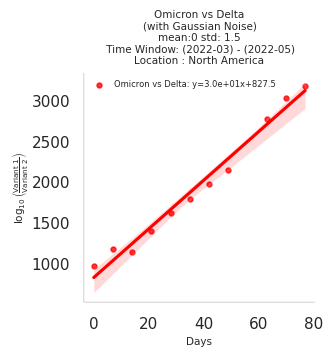

In [11]:
scatterplot('North America', df_weekly_sum, start = '2022-03', end = '2022-05', variant = 'Delta', mu = 0)

std_dev of South America: 1530.0905803738724
['2021-12']
Slope Values: [('South America', 0.045066462128622954)]
R-squared Values: 0.9241642270805768
p-value: 0.0386653928


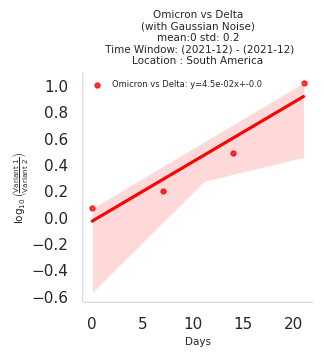

In [12]:
scatterplot('South America', df_weekly_sum, start = '2021-12', end = '2021-12', variant = 'Delta', mu = 0)

std_dev of Europe: 35452.5051769086
['2022-02', '2022-03']
Slope Values: [('Europe', 18.462756787764786)]
R-squared Values: 0.9962331257287642
p-value: 0.0000000167


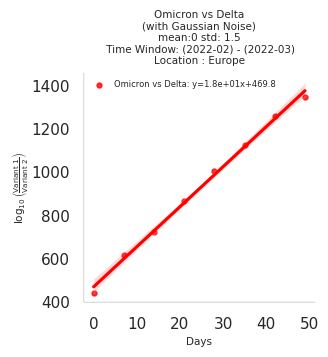

In [13]:
scatterplot('Europe', df_weekly_sum, start = '2022-02', end = '2022-03', variant = 'Delta', mu = 0)

std_dev of Oceania: 1101.6026838296386
['2022-01', '2022-02', '2022-03', '2022-04']
Slope Values: [('Oceania', 0.46904964616316724)]
R-squared Values: 0.9883901267832849
p-value: 0.0000000000


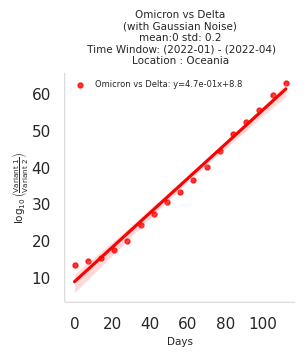

In [14]:
scatterplot('Oceania', df_weekly_sum, start = '2022-01', end = '2022-04', variant = 'Delta', mu = 0)

std_dev of Asia: 4915.618172975186
['2021-12', '2022-01']
Slope Values: [('Asia', 0.09814430374182577)]
R-squared Values: 0.9756621508208105
p-value: 0.0000006608


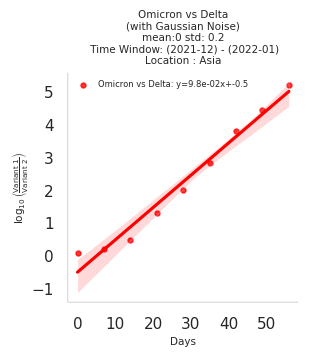

In [22]:
scatterplot('Asia', df_weekly_sum, start = '2021-12', end = '2022-01', variant = 'Delta', mu = 0)

std_dev of Africa: 602.1725914175602
['2021-11', '2021-12']
Slope Values: [('Africa', 0.06567392656920981)]
R-squared Values: 0.955632338184889
p-value: 0.0000054488


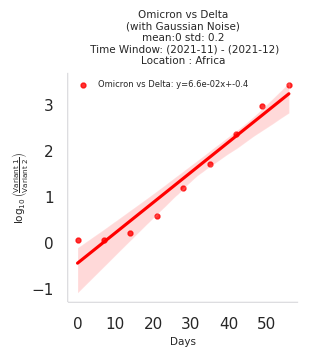

In [16]:
scatterplot('Africa', df_weekly_sum, start = '2021-11', end = '2021-12', variant = 'Delta', mu = 0)

# `Bar Plot` of the slope values in diffeerent `Countries`

In [17]:
slope_values_of_continents = pd.read_csv('Omicron_Vs_delta_slope_values_continents_with_noise.csv')
print(slope_values_of_continents)

        Location     Slope
0  North America  0.005939
1  South America  0.055641
2         Europe  0.009170
3        Oceania  0.006057
4           Asia  0.057634
5         Africa  0.033496


In [18]:
slope_values_of_continents = slope_values_of_continents.drop_duplicates()
print(slope_values_of_continents.describe())
print("\n")

# Find the minimum and maximum slope values
min_slope_value = slope_values_of_continents['Slope'].min()
max_slope_value = slope_values_of_continents['Slope'].max()

# Find the corresponding countries for the minimum and maximum slope values
min_slope_continents = slope_values_of_continents[slope_values_of_continents['Slope'] == min_slope_value]['Location']
max_slope_continents = slope_values_of_continents[slope_values_of_continents['Slope'] == max_slope_value]['Location']

# Print the results
print(f"Min Slope Value: {min_slope_value}")
print(f"Country: {', '.join(min_slope_continents)}")
print("\n")
print(f"Max Slope Value: {max_slope_value}")
print(f"Country: {', '.join(max_slope_continents)}")
print("\n")
print(f"Average Slope Value: {slope_values_of_continents['Slope'].mean()}")


          Slope
count  6.000000
mean   0.027990
std    0.024475
min    0.005939
25%    0.006835
50%    0.021333
75%    0.050105
max    0.057634


Min Slope Value: 0.0059389595434088
Country: North America


Max Slope Value: 0.0576341462286882
Country: Asia


Average Slope Value: 0.027989514683588113


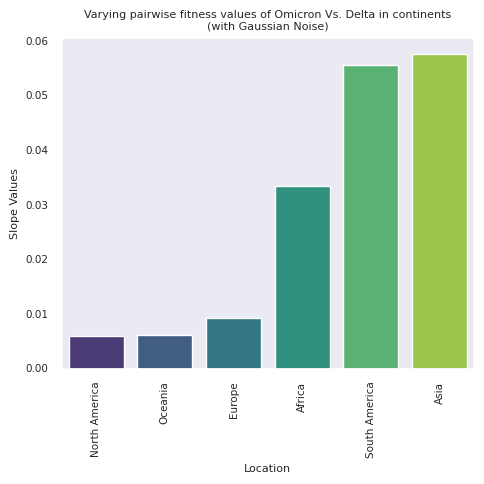

In [19]:
# Sort the DataFrame by 'Slope' column in ascending order
slope_values_of_continents = slope_values_of_continents.sort_values('Slope', ascending=True)

# Define the color palette
color_palette = sns.color_palette('viridis', len(slope_values_of_continents))

# Plot the bar plot with the specified color palette
plt.figure(figsize=(5, 5))
sns.barplot(x='Location', y='Slope', data=slope_values_of_continents, palette=color_palette)
plt.xlabel('Location', fontsize = 8)
plt.ylabel('Slope Values', fontsize =8)
plt.title('Varying pairwise fitness values of Omicron Vs. Delta in continents\n(with Gaussian Noise)', fontsize = 8)
plt.xticks(rotation=90)
plt.grid(False)  # Turn off the grid lines
plt.tight_layout()

# Specify the directory path
directory = "/scr/mjpantho/Pantho_differential_fitness/omicron_vs_delta_regression_plots_with_noise/"

# Create the directory if it doesn't exist
if not os.path.exists(directory):
    os.makedirs(directory)

# Save the figure to the specified directory with DPI set to 300
filename = os.path.join(directory, "continents_bar_plot_Omicron_vs_delta_with_noise.png")
plt.savefig(filename, dpi=300, bbox_inches="tight")

# Display the figure
plt.show()
